In [3]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve, roc_curve
from itertools import combinations, product
import matplotlib
import csv
import cvxpy as cp

In [4]:
#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#phase_dir = '../recomb_ihart.ms2'

ped_file = '../../DATA/ssc.hg38/ssc.ped'
phase_dir = '../recomb_ssc.hg38'

#ped_files = ['../../DATA/ihart.ms2/ihart.ped',
#            '../../DATA/ssc.hg38/ssc.ped']
#phase_dirs = ['../recomb_ihart.ms2', '../recomb_ssc.hg38']

#ped_file = '../../DATA/spark/sparkfam.ped'
#phase_dir = '../recomb_spark'

colors=['#ef6c00', '#4db6ac', '#ce93d8ff']
chroms = [str(x) for x in range(21, 22)] #+ ['X']



In [5]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))




ped loaded
children 9371


In [6]:
with open('%s/sibpairs.json' % phase_dir) as f:
    sibpairs = sorted([(x['family'], x['sibling1'], x['sibling2']) for x in json.load(f)])
    
sibpair_to_index = dict([(x, i) for i, x in enumerate(sibpairs)])

In [7]:
sample_to_phen = dict()
with open('../phenotypes/ssc/designated.unaffected.sibling.data/scq_life_raw.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    
    for pieces in reader:
        sample_to_phen[pieces[0]] = pieces[2:]
        
with open('../phenotypes/ssc/proband.data/scq_life_raw.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    
    for pieces in reader:
        sample_to_phen[pieces[0]] = pieces[2:]

aut_response = ['no', 'no', 'yes', 'yes', 'yes',
                'yes', 'yes', 'yes', 'no', 'yes',
                'yes', 'yes', 'yes', 'yes', 'yes',
                'yes', 'yes', 'yes', 'no', 'no',
                'no', 'no', 'no', 'no', 'no',
                'no', 'no', 'no', 'no', 'no',
                'no', 'no', 'no', 'no', 'no',
                'no', 'no', 'no', 'no', 'no']

phen = np.zeros((len(sibpairs), 40), dtype=int)
is_missing = np.zeros((len(sibpairs), 40), dtype=bool)

for i, sibpair in enumerate(sibpairs):
    if (sibpair[0]+'.p1') in sample_to_phen and (sibpair[0]+'.s1') in sample_to_phen:
        sib1_phen = sample_to_phen[sibpair[0] + ('.p1' if child_id_to_affected[sibpair[1]]=='2' else '.s1')]
        sib2_phen = sample_to_phen[sibpair[0] + ('.p1' if child_id_to_affected[sibpair[2]]=='2' else '.s1')]

        for j in range(40):
            if (sib1_phen[j] in {'yes', 'no'}) and (sib2_phen[j] in {'yes', 'no'}):
                phen[i, j] = (int(sib1_phen[j]==aut_response[j]) - int(sib2_phen[j]==aut_response[j]))
            else:
                is_missing[i, j] = True
    else:
        is_missing[i, :] = True

In [8]:
assert np.all(phen[is_missing]==0)

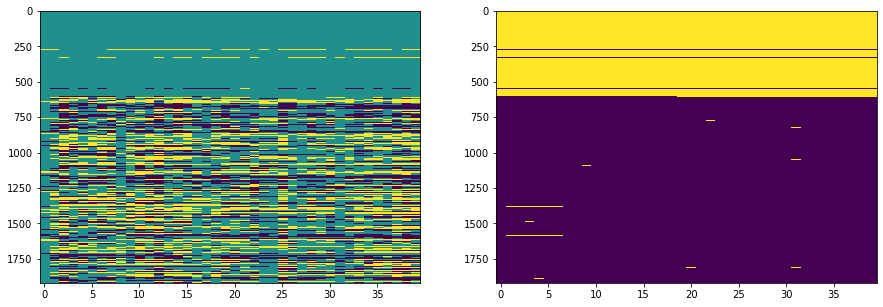

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(phen, aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(is_missing, aspect='auto')
plt.show()

In [10]:
with open('%s/deletions.json' % phase_dir) as f:
    deletions = json.load(f)

# filter deletions
deletions = [d for d in deletions if d['length']>=1000]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))
    
#deletions = [d for d in deletions if not d['is_hts']]
#print('remaining deletions', len(deletions))

remaining deletions 378644
remaining deletions 378644


In [102]:
X = []
positions = []
for chrom in [str(x) for x in range(1, 23)] + ['X']:
    chrom_ds = [d for d in deletions if d['chrom'] == chrom]
    poss = sorted(set([d['start_pos']-1 for d in chrom_ds if len(d['trans'])==1 and len(d['notrans'])==1]) | \
                  set([d['start_pos'] for d in chrom_ds if len(d['trans'])==1 and len(d['notrans'])==1]) | \
                  set([d['end_pos']-1 for d in chrom_ds if len(d['trans'])==1 and len(d['notrans'])==1]) | \
                  set([d['end_pos'] for d in chrom_ds if len(d['trans'])==1 and len(d['notrans'])==1]))
    
    pos_to_index = dict([(x, i) for i, x in enumerate(poss)])
    
    dels = np.zeros((len(sibpairs), len(poss)), dtype=int)
    for d in chrom_ds:
        if len(d['trans'])==1 and len(d['notrans'])==1:
            start_index = pos_to_index[d['start_pos']]
            end_index = pos_to_index[d['end_pos']]

            sibs = d['trans'] + d['notrans']
            if (d['family'], sibs[0], sibs[1]) not in sibpair_to_index:
                sibs = [sibs[1], sibs[0]]

            sibpair_index = sibpair_to_index[(d['family'], sibs[0], sibs[1])]
            
            if d['trans'][0]==sibs[0]:
                dels[sibpair_index, start_index:end_index] = 1
            else:
                dels[sibpair_index, start_index:end_index] = -1
    
    X.append(dels)
    positions.extend([(chrom, p) for p in poss])
X = np.hstack(X)
print(X.shape)
    

(1920, 198681)


In [103]:
sibpair_sex = np.array([int(child_id_to_sex[sib1]=='1')-int(child_id_to_sex[sib2]=='1') for (fam, sib1, sib2) in sibpairs])

is_ntaff = np.array([(child_id_to_affected[sib1]=='1') and (child_id_to_affected[sib2]=='2') for (fam, sib1, sib2) in sibpairs])
is_affnt = np.array([(child_id_to_affected[sib1]=='2') and (child_id_to_affected[sib2]=='1') for (fam, sib1, sib2) in sibpairs])


In [104]:
X = np.hstack((np.ones((len(sibpairs), 1)), sibpair_sex[:, np.newaxis], X))


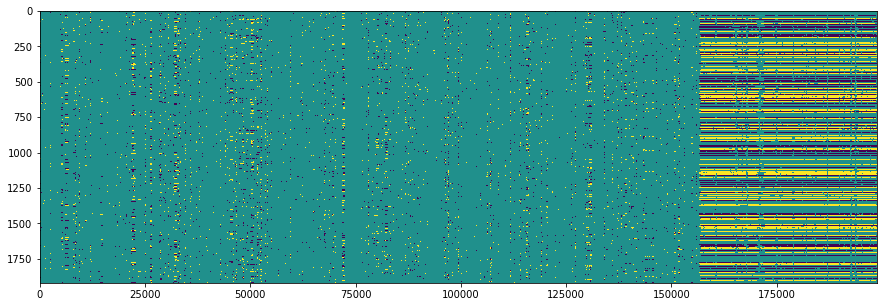

In [105]:
plt.figure(figsize=(15, 5))
plt.imshow(X, aspect='auto')
plt.show()

In [106]:

print(np.sum(X[:, 3:])/(X.shape[0]*(X.shape[1]-3)))
print(np.sum(X[:, 0])/X.shape[0])
print(np.sum(X[:, 1])/X.shape[0])
print(np.sum(X[:, 2])/X.shape[0])
print(np.sum(is_affnt)/len(sibpairs), np.sum(is_ntaff)/len(sibpairs))

-0.00398760989195356
1.0
-0.01875
0.0
0.49947916666666664 0.5005208333333333


In [107]:
def fit_A(B, lamb):
    
    k = B.shape[0]
    A = cp.Variable((X.shape[1], k))

    ll = 0
    
    for scq_index in range(40):
        is_ntaff = phen[:, scq_index]==-1
        is_affnt = phen[:, scq_index]==1

        log_likelihood = cp.sum(
            cp.multiply(is_affnt[is_affnt | is_ntaff], X[is_affnt | is_ntaff, :]@A@B[:, scq_index]) - cp.logistic(X[is_affnt | is_ntaff, :]@A@B[:, scq_index])
        )

        ll += log_likelihood/np.sum(is_affnt | is_ntaff)
    
    for chrom in chroms:
        indices = np.array([p[0]==chrom for p in positions])
        for i in range(k):
            ll -= lamb*cp.tv(A[2:, i][indices])

    problem = cp.Problem(cp.Maximize(ll), [A[2:, :]>=0])
    problem.solve(solver='MOSEK', verbose=True)
    return A.value


def fit_B(A, lamb):
    k = A.shape[1]
    B = cp.Variable((k, 40))

    ll = 0
    
    for scq_index in range(40):
        is_ntaff = phen[:, scq_index]==-1
        is_affnt = phen[:, scq_index]==1

        log_likelihood = cp.sum(
            cp.multiply(is_affnt[is_affnt | is_ntaff], X[is_affnt | is_ntaff, :] @A@B[:, scq_index]) - cp.logistic(X[is_affnt | is_ntaff, :]@A@B[:, scq_index])
        )

        ll += log_likelihood/np.sum(is_affnt | is_ntaff)

    problem = cp.Problem(cp.Maximize(ll), [B>=0])
    problem.solve(solver='MOSEK', verbose=True)
    return B.value
           



            
            

In [108]:
X.shape

(1920, 198683)

In [109]:
k = 5
A = np.random.randn(X.shape[1], k)
B = np.random.randn(k, 40)

In [110]:
for _ in range(5):
    A = fit_A(B, 0.1)
    B = fit_B(A, 0.1)

KeyboardInterrupt: 

[[ 0.00085293 -0.00671412  0.01477342  0.00062305 -0.00437047]
 [-0.22172163  0.12336371  0.56662623  0.08610899 -0.22077836]]


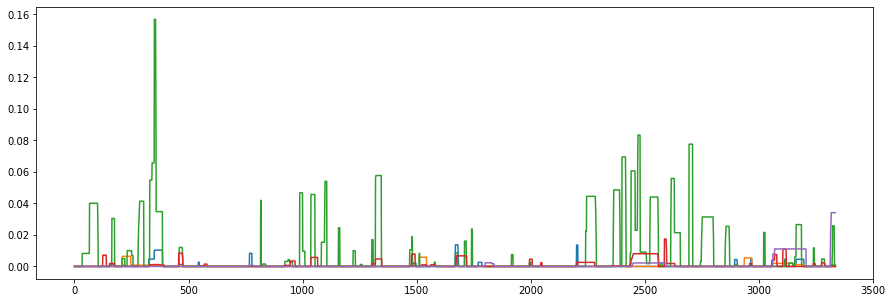

In [87]:
plt.figure(figsize=(15, 5))
print(A[:2, :])
for i in range(k):
    plt.plot(A[2:, i])
    
plt.show()

[[3.58166283e-10 3.58494001e-10 2.65024897e+00 1.00500182e+00
  1.85757738e+00 1.88515281e+00 2.37605093e+00 2.26808477e+00
  1.82434953e-01 1.09536698e+00 1.81801495e+00 2.52373877e+00
  3.00160457e-08 1.69055027e+00 1.57686878e+00 2.88102036e+00
  5.12941437e+00 2.84726514e+00 3.48712491e+00 3.25887278e+00
  4.36794651e+00 4.35959386e+00 7.85316195e-10 4.54513300e+00
  7.33325858e+00 3.71846257e+00 5.23519760e+00 1.24428818e+01
  4.43691450e+00 9.52955493e+00 6.52709899e+00 7.28879179e+00
  7.30810082e+00 2.49281105e+00 1.92170031e+00 2.82267043e+00
  3.51383532e+00 5.12480675e+00 2.42706553e+00 2.60239330e+00]
 [5.09051148e-11 3.03344798e-08 1.05587475e+00 1.02777563e+00
  2.13465704e+00 7.04185417e-10 8.63992769e-01 2.12390953e-01
  4.13365086e-11 9.52597700e-10 3.54689059e-10 1.79852340e-09
  6.01454515e-01 9.31474994e-11 1.93403613e-10 1.16647883e-01
  1.74719197e-10 1.69561255e+00 3.24699676e-10 2.18528017e-10
  5.81150879e-01 1.87172038e+00 3.80810527e-10 1.19459971e-10
  3.309

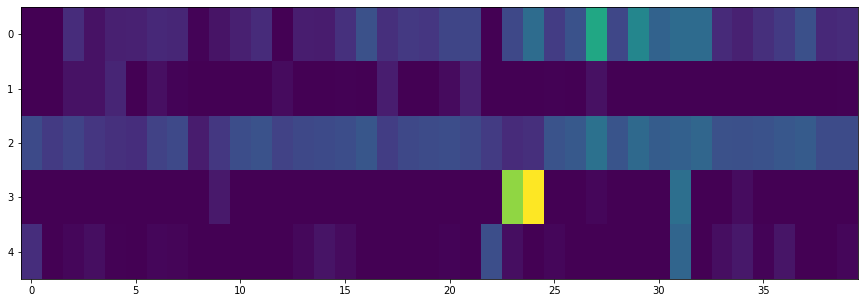

In [88]:
print(B)
plt.figure(figsize=(15, 5))
plt.imshow(B, aspect='auto')
plt.show()

In [89]:
beta = A.dot(B)
print(beta.shape)

(3337, 40)


In [90]:
#beta = np.zeros((len(positions)+2, 40))
#for i in range(40):
#    try:
#        beta[:, i] = np.load('%s/delmodel.0.10.%d.npy' % (phase_dir, i))
#    except:
#        print('missing', i)#
#
#    print(beta[0:2, i])
#    #print(beta[2:8, i])
#    plt.hist(np.clip(beta[4:, i], None, 0.05), bins=np.arange(0, 0.051, 0.001), log=True, alpha=0.2)
#plt.show()

In [91]:
print(np.where(np.isclose(beta[2:, :], np.max(beta[2:, :]))))

(array([350, 351, 352, 353, 354, 355]), array([27, 27, 27, 27, 27, 27]))


In [92]:
scq_index = 10

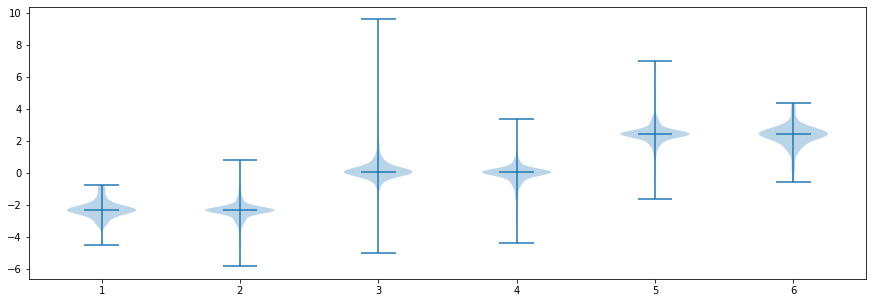

In [93]:
plt.figure(figsize=(15, 5))
plt.violinplot([X.dot(beta[:, scq_index])[is_affnt & (sibpair_sex==-1)],
                X.dot(beta[:, scq_index])[~is_affnt & (sibpair_sex==-1)],
                X.dot(beta[:, scq_index])[is_affnt & (sibpair_sex==0)],
                X.dot(beta[:, scq_index])[~is_affnt & (sibpair_sex==0)],
                X.dot(beta[:, scq_index])[is_affnt & (sibpair_sex==1)],
                X.dot(beta[:, scq_index])[~is_affnt & (sibpair_sex==1)]], showmedians=True)
plt.show()

In [94]:
chrom_starts = []
for i, p in enumerate(positions):
    if len(chrom_starts)==0 or p[0]!=positions[chrom_starts[-1]][0]:
        chrom_starts.append(i)

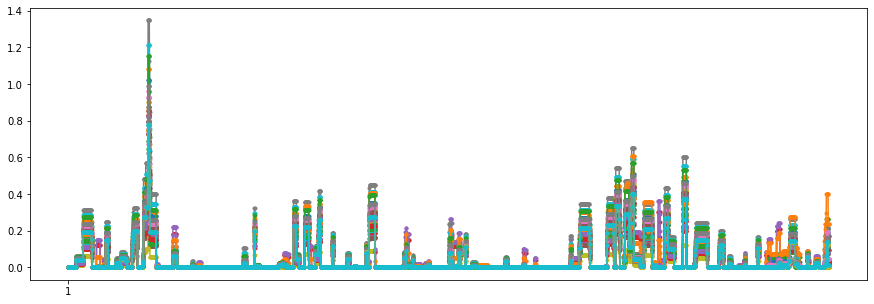

In [95]:
plt.figure(figsize=(15, 5))
for scq_index in range(40):
    plt.plot(beta[2:, scq_index], marker='.')
plt.xticks(chrom_starts, [str(x) for x in range(1, 23)]+['X'])
#plt.xlim([np.argmax(beta.value[4:])-10, np.argmax(beta.value[4:])+10])
#plt.xlim([0, chrom_starts[1]])
plt.show()

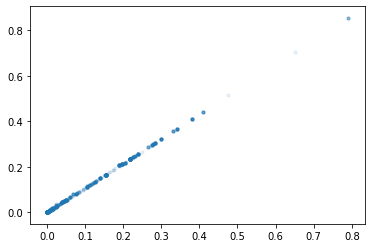

In [96]:
plt.scatter(beta[2:, 10], beta[2:, 11], marker='.', alpha=0.1)
plt.show()

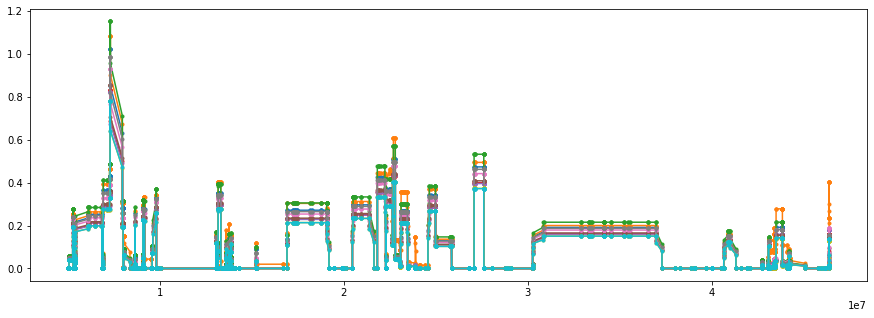

In [97]:
chrom = '21'
indices = np.array([p[0]==chrom for p in positions])
x = np.array([p[1] for p in positions if p[0]==chrom])

plt.figure(figsize=(15, 5))
for scq_index in range(30, 40):
    plt.plot(x, beta[2:, scq_index][indices], marker='.')
#plt.xticks(chrom_starts, [str(x) for x in range(1, 23)]+['X'])
#plt.xlim([np.argmax(beta.value[4:])-10, np.argmax(beta.value[4:])+10])
#plt.xlim([0, chrom_starts[1]])
plt.show()

In [98]:
print(np.sum(np.isclose(beta[2:-1], 0) & ~np.isclose(beta[3:], 0)))

1714


In [99]:
print(np.sum((X[:, 2:][:, np.argmax(beta[2:, scq_index])]==1) & is_affnt))
print(np.sum((X[:, 2:][:, np.argmax(beta[2:, scq_index])]==1) & ~is_affnt))
print(np.sum((X[:, 2:][:, np.argmax(beta[2:, scq_index])]==-1) & is_affnt))
print(np.sum((X[:, 2:][:, np.argmax(beta[2:, scq_index])]==-1) & ~is_affnt))

2
0
0
0


In [100]:
scq_index = 31
indices = np.isclose(beta[2:, scq_index], np.max(beta[2:, scq_index]))


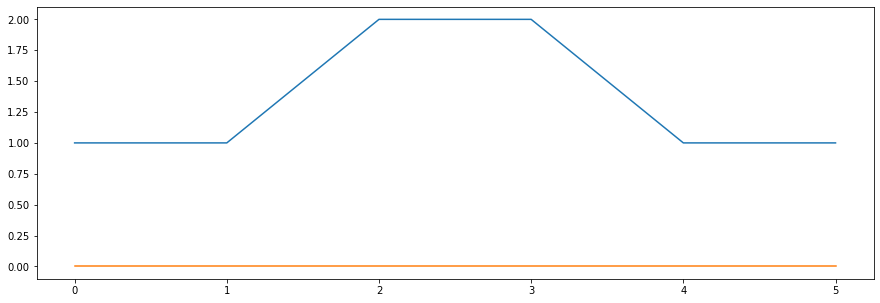

In [101]:
plt.figure(figsize=(15, 5))
plt.plot(np.sum((X[is_affnt, 2:][:, indices]==1), axis=0)+np.sum((X[~is_affnt, 2:][:, indices]==-1), axis=0))
plt.plot(np.sum((X[~is_affnt, 2:][:, indices]==1), axis=0)+np.sum((X[is_affnt, 2:][:, indices]==-1), axis=0))
plt.show()

In [74]:
print([positions[x] for x in np.where(np.isclose(beta[2:, scq_index], np.max(beta[2:, scq_index])))[0]])
print(len(positions), len(beta[2:]))


[('21', 7305444), ('21', 7311612), ('21', 7311613), ('21', 7315185), ('21', 7315186), ('21', 7322469)]
3335 3335
